# Introduction to ptype

This notebook shows how to use ptype to infer types for the columns of a dataframe, and then transform the dataframe into an appropriately typed one. 

We start by showing what this data cleaning problem looks like without ptype. First, the user loads a dataset using Pandas `read_csv` and attempts to run a linear regression on the data. They encounter a `could not convert string to float` error because some missing data is encoded as `?`. For this task, they choose to solve the problem by using Pandas to change the encoding of missing data and then remove any rows where data is missing. They are then able to run the regression  without error and complete the analysis task.

With ptype, the data scientist loads the data using the `dtype=’str’` option of Pandas `read_csv`. This loads the dataframe into an untyped (string) representation, from which  ptype is able to infer a “schema”. The schema represents ptype’s best guess at a suitable datatype for each column. The user can then ask ptype to adjust the type of dataframe to match the inferred schema and replace any missing values by the special Pandas value `NA`.


In [1]:
# Preamble to run notebook in context of source package.
import sys
sys.path.insert(0, '../')

In [2]:
from IPython.core.display import display
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()
import numpy as np
import pandas as pd

from utils import scatter_plot

## The analytical task

This dataset is commonly used for a regression task, where the goal is to predict the price of an automobile given its attributes.

In [3]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]

df = pd.read_csv('../data/auto.csv', names = headers)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']
target = ['price']

X = df[features]
y = df[target]

df = df[features+target]
df.head()

,horsepower,curb-weight,engine-size,highway-mpg,price
0,111,2548,130,27,13495
1,111,2548,130,27,16500
2,154,2823,152,26,16500
3,102,2337,109,30,13950
4,115,2824,136,22,17450


In [5]:
# to see the error message, uncomment the following

lm = LinearRegression()
# lm.fit(X, y)
# y_hat = lm.predict(X)

## A solution using standard Pandas features

How might we solve this problem? The solution below is inspired by Kaggle (see https://www.kaggle.com/fazilbtopal/data-wrangling and https://www.kaggle.com/fazilbtopal/model-development-and-evaluation-with-python).

We notice that some data entries are valued `?` and that they cannot be processed with the `fit` function. Although it is not directly obvious which data entries are valued `?`, we can query the dataframe to determine the occurences of `?`.

In [6]:
df[(df['horsepower']=='?') | (df['price']=='?')]

,horsepower,curb-weight,engine-size,highway-mpg,price
9,160,3053,131,22,?
44,70,1874,90,43,?
45,70,1909,90,43,?
129,288,3366,203,28,?
130,?,2579,132,31,9295
131,?,2460,132,31,9895


Note that this also leads Pandas to misclassify two data columns as `object` rather than `int64`.

In [7]:
df.dtypes

horsepower     object
curb-weight     int64
engine-size     int64
highway-mpg     int64
price          object
dtype: object

We need to "clean" the `horsepower` and `price` columns in terms of missing values. Without Ptype, we might do the following:

In [8]:
# replace missing data encoding
df['horsepower'].replace("?", np.nan, inplace = True)
df['price'].replace("?", np.nan, inplace = True)

# drop rows
n = df.shape[0]
df.dropna(subset=["horsepower", "price"], axis=0, inplace=True)
print("# rows deleted = " + str(n-df.shape[0]))

# update the indices
df.reset_index(drop=True, inplace=True)

# rows deleted = 6


In [9]:
df.dtypes

horsepower     object
curb-weight     int64
engine-size     int64
highway-mpg     int64
price          object
dtype: object

Although this column typing does not itself cause any errors, we may want to update the types to more accurately reflect the cleaned data:

In [10]:
df = df.astype(int)
df.dtypes

horsepower     int64
curb-weight    int64
engine-size    int64
highway-mpg    int64
price          int64
dtype: object

Now we can re-run the analysis and plot some numbers.

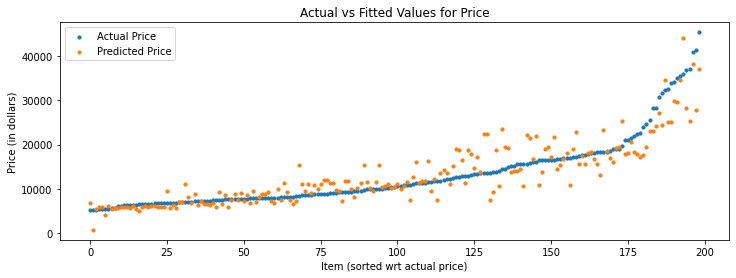

In [11]:
X = df[features].values
y = df[target].values

lm.fit(X, y)
y_hat = lm.predict(X)

def scatter_plot(y, y_hat):
    plt.figure(figsize=(12, 4))

    sorted_indices = sorted(range(len(y)),key=y.__getitem__)
    plt.scatter(range(len(y)), y[sorted_indices], label='Actual Price', s=10)
    plt.scatter(range(len(y)), y_hat[sorted_indices], label='Predicted Price', s=10)

    plt.title('Actual vs Fitted Values for Price')
    plt.xlabel('Item (sorted wrt actual price)')
    plt.ylabel('Price (in dollars)')
    plt.legend()
    plt.show()

scatter_plot(y, y_hat)

# Solving the problem with ptype

Let's now revisit the problem and see how we can use ptype to resolve it. Note that we now use an additional parameter of the `read_csv` function: we set `dtype` to `str` so that all data entries are parsed as strings. This is needed as ptype processes each data value as a string.

In [12]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]

df = pd.read_csv('../data/auto.csv', names = headers, dtype='str')
df = df[features+target]
df.head()

,horsepower,curb-weight,engine-size,highway-mpg,price
0,111,2548,130,27,13495
1,111,2548,130,27,16500
2,154,2823,152,26,16500
3,102,2337,109,30,13950
4,115,2824,136,22,17450


In [13]:
from ptype.Ptype import Ptype

ptype = Ptype()

ptype can infer a “schema” specifying the most likely type for each column. The schema object can also supply other relevant metadata about missing or anomalous values.

In [14]:
schema = ptype.schema_fit(df)
ptype.show_schema()

,horsepower,curb-weight,engine-size,highway-mpg,price
type,integer,integer,integer,integer,integer
normal values,"[100, 101, 102, 106, 110, 111, 112, 114, 115, ...","[1488, 1713, 1819, 1837, 1874, 1876, 1889, 189...","[103, 108, 109, 110, 111, 119, 120, 121, 122, ...","[16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 2...","[10198, 10245, 10295, 10345, 10595, 10698, 107..."
ratio of normal values,0.99,1,1,1,0.98
missing values,[?],[],[],[],[?]
ratio of missing values,0.01,0,0,0,0.02
anomalous values,[],[],[],[],[]
ratio of anomalous values,0,0,0,0,0


Using the schema, we can obtain a more specifically-typed dataframe directly. 

In [15]:
df = ptype.schema_transform(df, schema)

In [16]:
df[(df['horsepower'].isna()) | (df['price'].isna())]

,horsepower,curb-weight,engine-size,highway-mpg,price
9,160,3053,131,22,<NA>
44,70,1874,90,43,<NA>
45,70,1909,90,43,<NA>
129,288,3366,203,28,<NA>
130,<NA>,2579,132,31,9295
131,<NA>,2460,132,31,9895


In [17]:
df.dtypes

horsepower     Int64
curb-weight    Int64
engine-size    Int64
highway-mpg    Int64
price          Int64
dtype: object

We can now drop the rows with missing data as we did previously:

In [18]:
# drop rows
n = df.shape[0]
df.dropna(subset=["horsepower", "price"], axis=0, inplace=True)
print("# rows deleted = " + str(n-df.shape[0]))

# update the indices
df.reset_index(drop=True, inplace=True)

# rows deleted = 6


And finally run the analysis:

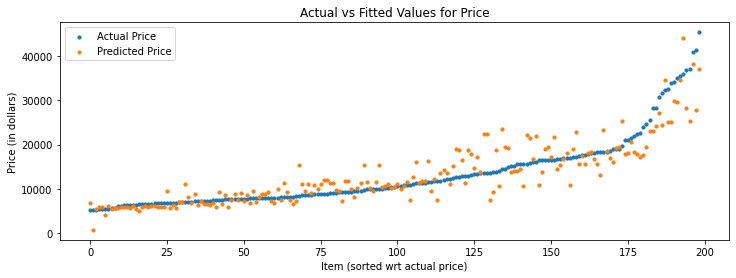

In [19]:
X = df[features].values
y = df[target].values

lm = LinearRegression()
lm.fit(X, y)
y_hat = lm.predict(X)

scatter_plot(y, y_hat)